# Introduction to Parallelization and High-Performance Computing

**DSC 232R - Big Data Analysis Using Spark**

In this notebook, we'll explore:
1. Why parallelization is necessary
2. Measuring the limits of single-machine performance
3. Amdahl's Law in practice
4. Comparing parallelization approaches

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 1. The Single-Machine Wall

Let's first understand why we need parallelization by hitting the limits of single-machine performance.

In [ ]:
# How many CPU cores do we have?
n_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {n_cores}")

# How much memory?
import psutil
memory_gb = psutil.virtual_memory().total / (1024**3)
print(f"Total RAM: {memory_gb:.1f} GB")

Available CPU cores: 2
Total RAM: 12.7 GB


### Serial vs Parallel: A Simple Example

Let's compute the sum of squares for a large array - first serially, then in parallel.

In [ ]:
def sum_of_squares_serial(arr):
    """Compute sum of squares serially"""
    total = 0
    for x in arr:
        total += x * x
    return total

def sum_of_squares_numpy(arr):
    """Compute sum of squares with numpy (vectorized)"""
    return np.sum(arr ** 2)

def sum_of_squares_chunk(chunk):
    """Process a chunk - for parallel execution"""
    return np.sum(chunk ** 2)

In [ ]:
# Create a large array
N = 10_000_000
data = np.random.random(N)

print(f"Array size: {N:,} elements")
print(f"Memory usage: {data.nbytes / 1024**2:.1f} MB")

Array size: 10,000,000 elements
Memory usage: 76.3 MB


In [ ]:
%%time
# Pure Python serial (slow!)
# Note: This is intentionally slow to demonstrate the point
result_serial = sum_of_squares_serial(data[:100_000])  # Only 100K to save time
print(f"Serial result (100K elements): {result_serial:.2f}")

Serial result (100K elements): 33235.21
CPU times: user 31 ms, sys: 2.04 ms, total: 33.1 ms
Wall time: 34.8 ms


In [ ]:
%%time
# Numpy vectorized (fast, but single-threaded)
result_numpy = sum_of_squares_numpy(data)
print(f"Numpy result: {result_numpy:.2f}")

Numpy result: 3332180.25
CPU times: user 19.9 ms, sys: 27.7 ms, total: 47.6 ms
Wall time: 51.4 ms


In [ ]:
%%time
# Parallel with multiprocessing
n_workers = min(n_cores, 4)  # Use up to 4 workers
chunks = np.array_split(data, n_workers)

with ProcessPoolExecutor(max_workers=n_workers) as executor:
    results = list(executor.map(sum_of_squares_chunk, chunks))

result_parallel = sum(results)
print(f"Parallel result ({n_workers} workers): {result_parallel:.2f}")

Parallel result (2 workers): 3332180.25
CPU times: user 52 ms, sys: 126 ms, total: 178 ms
Wall time: 446 ms


### Observation

- Pure Python serial is extremely slow
- Numpy is fast but uses only one core
- Parallel processing can split work across cores

But there's overhead! Let's measure it.

## 2. Measuring Speedup and Overhead

Let's systematically measure how speedup changes with the number of workers.

In [ ]:
def measure_parallel_speedup(data, max_workers=None):
    """Measure execution time for different numbers of workers"""
    if max_workers is None:
        max_workers = min(n_cores, 8)

    results = []

    # Baseline: single worker
    start = time.time()
    baseline_result = sum_of_squares_chunk(data)
    baseline_time = time.time() - start
    results.append((1, baseline_time, 1.0))

    # Multiple workers
    for n_workers in range(2, max_workers + 1):
        chunks = np.array_split(data, n_workers)

        start = time.time()
        with ProcessPoolExecutor(max_workers=n_workers) as executor:
            chunk_results = list(executor.map(sum_of_squares_chunk, chunks))
        parallel_time = time.time() - start

        speedup = baseline_time / parallel_time
        results.append((n_workers, parallel_time, speedup))

    return results

In [ ]:
# Run the measurement
print("Measuring speedup (this may take a moment)...")
speedup_results = measure_parallel_speedup(data)

# Display results
print("\n" + "="*50)
print(f"{'Workers':>8} {'Time (s)':>12} {'Speedup':>10}")
print("="*50)
for workers, time_s, speedup in speedup_results:
    print(f"{workers:>8} {time_s:>12.4f} {speedup:>10.2f}x")

Measuring speedup (this may take a moment)...

 Workers     Time (s)    Speedup
       1       0.0358       1.00x
       2       0.5492       0.07x


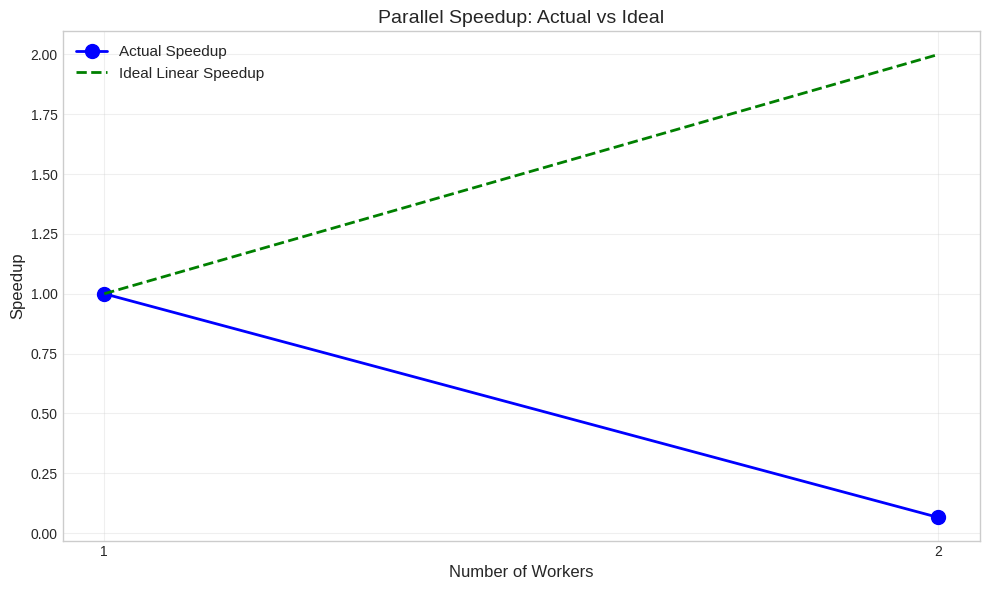

In [ ]:
# Visualize speedup
workers = [r[0] for r in speedup_results]
speedups = [r[2] for r in speedup_results]

fig, ax = plt.subplots(figsize=(10, 6))

# Actual speedup
ax.plot(workers, speedups, 'bo-', linewidth=2, markersize=10, label='Actual Speedup')

# Ideal linear speedup
ax.plot(workers, workers, 'g--', linewidth=2, label='Ideal Linear Speedup')

ax.set_xlabel('Number of Workers', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title('Parallel Speedup: Actual vs Ideal', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(workers)

plt.tight_layout()
plt.show()

### Why isn't speedup linear?

1. **Communication overhead**: Data must be serialized and sent to workers
2. **Process startup**: Creating worker processes takes time
3. **Synchronization**: Workers must coordinate at the end
4. **Serial portions**: Some code can't be parallelized (Amdahl's Law)

## 3. Amdahl's Law in Practice

Amdahl's Law gives us the theoretical maximum speedup:

$$S(n) = \frac{1}{(1-p) + \frac{p}{n}}$$

Where:
- $p$ = parallelizable fraction
- $n$ = number of processors
- $S(n)$ = speedup

In [ ]:
def amdahl_speedup(p, n):
    """Calculate theoretical speedup using Amdahl's Law

    Args:
        p: Parallelizable fraction (0 to 1)
        n: Number of processors
    """
    return 1 / ((1 - p) + p / n)

def max_speedup(p):
    """Maximum possible speedup (as n approaches infinity)"""
    return 1 / (1 - p)

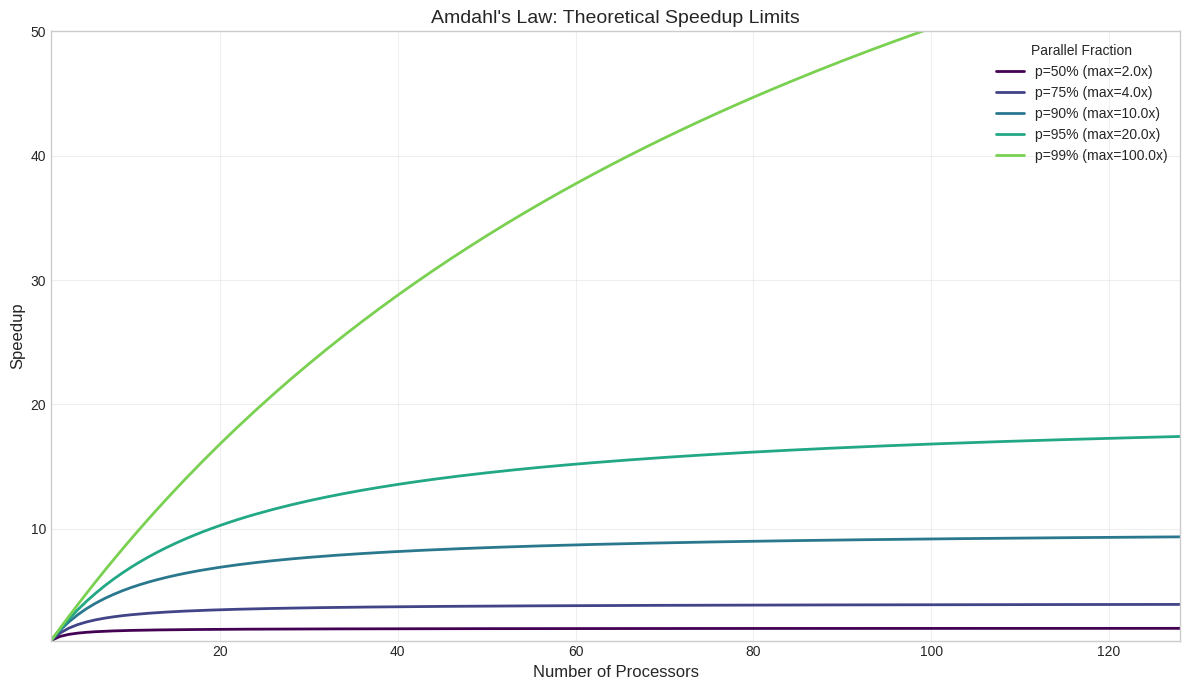

In [ ]:
# Visualize Amdahl's Law
processors = np.arange(1, 129)
parallel_fractions = [0.5, 0.75, 0.9, 0.95, 0.99]

fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(parallel_fractions)))

for p, color in zip(parallel_fractions, colors):
    speedups = [amdahl_speedup(p, n) for n in processors]
    ax.plot(processors, speedups, color=color, linewidth=2,
            label=f'p={p:.0%} (max={max_speedup(p):.1f}x)')

ax.set_xlabel('Number of Processors', fontsize=12)
ax.set_ylabel('Speedup', fontsize=12)
ax.set_title("Amdahl's Law: Theoretical Speedup Limits", fontsize=14)
ax.legend(title='Parallel Fraction', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(1, 128)
ax.set_ylim(1, 50)

plt.tight_layout()
plt.show()

In [ ]:
# Interactive table showing speedup limits
print("Maximum Speedup by Parallel Fraction")
print("="*50)
print(f"{'Parallel %':>12} {'Max Speedup':>15} {'Meaning':>20}")
print("="*50)

examples = [
    (0.50, "Half parallelizable"),
    (0.75, "Mostly parallelizable"),
    (0.90, "Highly parallelizable"),
    (0.95, "Very parallelizable"),
    (0.99, "Almost all parallel"),
    (0.999, "99.9% parallel"),
]

for p, meaning in examples:
    print(f"{p:>11.1%} {max_speedup(p):>15.1f}x {meaning:>20}")

Maximum Speedup by Parallel Fraction
  Parallel %     Max Speedup              Meaning
      50.0%             2.0x  Half parallelizable
      75.0%             4.0x Mostly parallelizable
      90.0%            10.0x Highly parallelizable
      95.0%            20.0x  Very parallelizable
      99.0%           100.0x  Almost all parallel
      99.9%          1000.0x       99.9% parallel


### Key Insight

Even a small serial fraction severely limits speedup!

- If 5% of your code is serial, maximum speedup is 20x
- If 1% is serial, maximum speedup is 100x

This is why optimizing the serial portions of code is crucial.

## 4. A Realistic Example: Image Processing Pipeline

Let's simulate a data processing pipeline with both serial and parallel components.

In [ ]:
def simulate_pipeline(n_items, n_workers, serial_fraction=0.1):
    """Simulate a processing pipeline

    Pipeline stages:
    1. Load data (serial) - simulated with sleep
    2. Process items (parallel)
    3. Aggregate results (serial)
    """
    # Simulated processing time per item (seconds)
    process_time_per_item = 0.001

    # Serial time is fixed (loading, aggregation)
    serial_time = n_items * process_time_per_item * serial_fraction

    # Parallel time depends on workers
    parallel_work = n_items * process_time_per_item * (1 - serial_fraction)
    parallel_time = parallel_work / n_workers

    # Add overhead proportional to number of workers
    overhead = 0.01 * n_workers

    total_time = serial_time + parallel_time + overhead

    return total_time, serial_time, parallel_time, overhead

In [ ]:
# Simulate processing 10,000 items
n_items = 10000
worker_counts = [1, 2, 4, 8, 16, 32, 64, 128]

results_90 = [simulate_pipeline(n_items, w, serial_fraction=0.10) for w in worker_counts]
results_50 = [simulate_pipeline(n_items, w, serial_fraction=0.50) for w in worker_counts]

# Calculate speedups
base_90 = results_90[0][0]
base_50 = results_50[0][0]

speedups_90 = [base_90 / r[0] for r in results_90]
speedups_50 = [base_50 / r[0] for r in results_50]

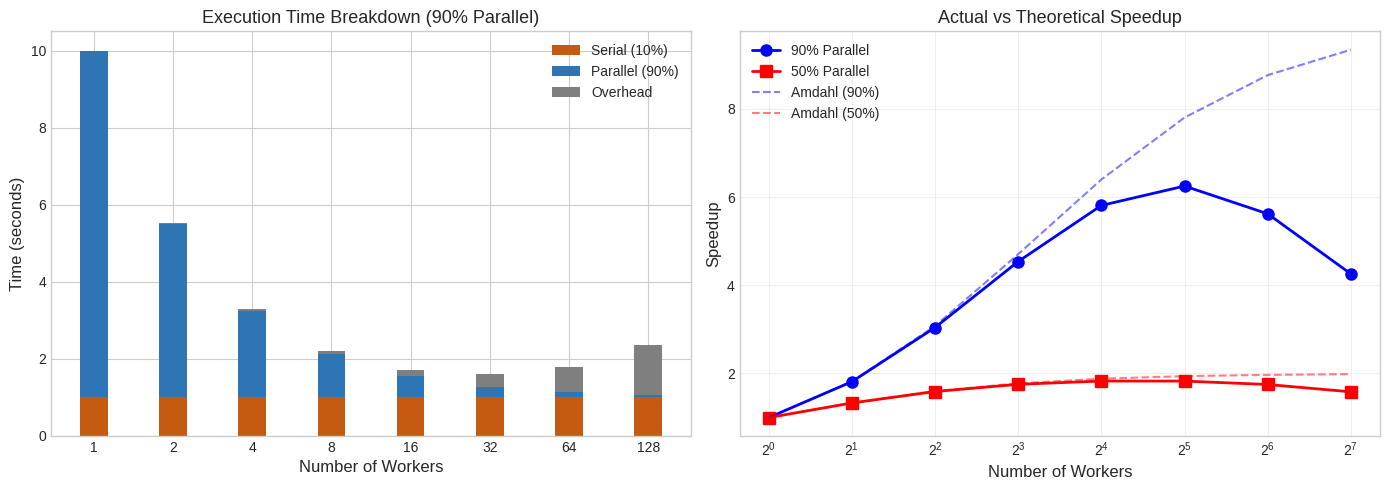

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Execution time breakdown
ax1 = axes[0]
width = 0.35
x = np.arange(len(worker_counts))

serial_times = [r[1] for r in results_90]
parallel_times = [r[2] for r in results_90]
overheads = [r[3] for r in results_90]

ax1.bar(x, serial_times, width, label='Serial (10%)', color='#C55A11')
ax1.bar(x, parallel_times, width, bottom=serial_times, label='Parallel (90%)', color='#2E75B6')
ax1.bar(x, overheads, width, bottom=[s+p for s,p in zip(serial_times, parallel_times)],
        label='Overhead', color='#7F7F7F')

ax1.set_xlabel('Number of Workers', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Execution Time Breakdown (90% Parallel)', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(worker_counts)
ax1.legend()

# Right: Speedup comparison
ax2 = axes[1]
ax2.plot(worker_counts, speedups_90, 'b-o', linewidth=2, markersize=8, label='90% Parallel')
ax2.plot(worker_counts, speedups_50, 'r-s', linewidth=2, markersize=8, label='50% Parallel')
ax2.plot(worker_counts, [amdahl_speedup(0.9, w) for w in worker_counts],
         'b--', alpha=0.5, label='Amdahl (90%)')
ax2.plot(worker_counts, [amdahl_speedup(0.5, w) for w in worker_counts],
         'r--', alpha=0.5, label='Amdahl (50%)')

ax2.set_xlabel('Number of Workers', fontsize=12)
ax2.set_ylabel('Speedup', fontsize=12)
ax2.set_title('Actual vs Theoretical Speedup', fontsize=13)
ax2.legend()
ax2.set_xscale('log', base=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Connecting to HPC

On your laptop, you might have 4-16 cores. On SDSC Expanse:

| Your Machine | SDSC Expanse |
|--------------|-------------|
| ~8 cores | 93,184 cores |
| ~16 GB RAM | 186 TB RAM |
| Local disk | 12 PB Lustre |

But more cores doesn't always mean faster! Amdahl's Law still applies.

In [ ]:
# What speedup could we achieve on Expanse?
expanse_cores = 93184

print("Theoretical Maximum Speedup on SDSC Expanse")
print("="*50)
print(f"{'Parallel %':>12} {'Max Speedup':>15} {'% of Cores Used':>18}")
print("="*50)

for p in [0.90, 0.95, 0.99, 0.999, 0.9999]:
    speedup = amdahl_speedup(p, expanse_cores)
    efficiency = (speedup / expanse_cores) * 100
    print(f"{p:>11.2%} {speedup:>15.1f}x {efficiency:>17.4f}%")

print("\nKey insight: Even with 93K cores, serial code is the bottleneck!")

Theoretical Maximum Speedup on SDSC Expanse
  Parallel %     Max Speedup    % of Cores Used
     90.00%            10.0x            0.0107%
     95.00%            20.0x            0.0215%
     99.00%            99.9x            0.1072%
     99.90%           989.4x            1.0618%
     99.99%          9030.9x            9.6915%

Key insight: Even with 93K cores, serial code is the bottleneck!


## Summary

### What We Learned

1. **Single machines have limits** - RAM, CPU cores, I/O all constrain performance

2. **Parallelization helps but has overhead** - Communication, synchronization, and process startup all cost time

3. **Amdahl's Law is crucial** - Even small serial fractions severely limit maximum speedup

4. **HPC provides massive resources** - SDSC Expanse has 93K+ cores, but efficient use requires understanding parallelism

### What's Next

In the next module, we'll learn how to:
- Use SLURM to submit jobs to HPC clusters
- Configure Spark for HPC environments
- Use Singularity containers for reproducibility

## Exercises

### Exercise 1: Amdahl's Law Calculator

Write a function that, given a target speedup, calculates the minimum parallelizable fraction required.

In [ ]:
# Exercise 1: Your code here
def required_parallel_fraction(target_speedup, n_processors):
    """
    Calculate the minimum parallel fraction needed to achieve target_speedup
    with n_processors.

    Hint: Rearrange Amdahl's Law to solve for p
    """
    # YOUR CODE HERE
    pass

# Test: What parallel fraction do we need to get 10x speedup with 16 processors?
# required_parallel_fraction(10, 16)

### Exercise 2: Parallel Map-Reduce

Implement a parallel word count using `ProcessPoolExecutor`.

In [ ]:
# Exercise 2: Your code here
from collections import Counter

# Sample text (Moby Dick excerpt)
sample_text = """
Call me Ishmael. Some years ago never mind how long precisely having little or no money
in my purse and nothing particular to interest me on shore I thought I would sail about
a little and see the watery part of the world. It is a way I have of driving off the spleen
and regulating the circulation. Whenever I find myself growing grim about the mouth whenever
it is a damp drizzly November in my soul whenever I find myself involuntarily pausing before
coffin warehouses and bringing up the rear of every funeral I meet.
"""

def word_count_chunk(text_chunk):
    """Count words in a text chunk"""
    # YOUR CODE HERE
    pass

def parallel_word_count(text, n_workers=4):
    """Parallel word count using ProcessPoolExecutor"""
    # YOUR CODE HERE
    pass

# Test your implementation
# result = parallel_word_count(sample_text * 1000)  # Repeat to make it larger
# print(result.most_common(10))

### Exercise 3: Efficiency Analysis

Given the following scenario, calculate the optimal number of workers:

- Processing 1 million records
- Each record takes 1ms to process (parallelizable)
- Setup time is 5 seconds (serial)
- Aggregation time is 2 seconds (serial)
- Overhead per worker is 0.5 seconds

In [ ]:
# Exercise 3: Your analysis here
def calculate_total_time(n_workers):
    """Calculate total processing time for given number of workers"""
    n_records = 1_000_000
    process_time_per_record = 0.001  # 1ms
    setup_time = 5  # seconds
    aggregation_time = 2  # seconds
    overhead_per_worker = 0.5  # seconds

    # YOUR CODE HERE
    # Calculate: serial_time + parallel_time + overhead
    pass

# Find optimal number of workers by testing 1 to 64
# for n in [1, 2, 4, 8, 16, 32, 64]:
#     print(f"Workers: {n}, Time: {calculate_total_time(n):.2f}s")